In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm_notebook
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/files')

Drive already mounted at /content/files; to attempt to forcibly remount, call drive.mount("/content/files", force_remount=True).


In [3]:
class DocsDataset(Dataset):
    def __init__(self, dir, label, size, transform = None):
        self.path = dir
        self.labels = label
        self.size = size
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = cv2.imread(str(self.path[idx]))
        label = self.labels[idx]
        if self.transform:
            img = cv2.resize(img, self.size)
            img = img.transpose((2, 0, 1))

        return torch.tensor(img), label


In [4]:
tz_dirs = list(Path("/content/files/MyDrive/train_sample/tz").glob('*'))
npa_dirs = list(Path("/content/files/MyDrive/train_sample/npa").glob('*'))
all_dirs = npa_dirs + tz_dirs
all_labels = [0] * len(npa_dirs) + [1] * len(tz_dirs)

In [5]:
from sklearn.model_selection import train_test_split

dirs_train, dirs_test, labels_train, labels_test = train_test_split(
    all_dirs, 
    all_labels, 
    test_size=0.3,
    random_state = 42)

In [6]:
training_data = DocsDataset(dirs_train, labels_train, size = (600, 600), transform=True)
test_data = DocsDataset(dirs_test, labels_test, size = (600, 600), transform=True)

In [7]:
train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

In [8]:
class DocTypeNet(torch.nn.Module):
    def __init__(self):
        super(DocTypeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding = 0)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2)
        
        self.fc1 = torch.nn.Linear(298 * 298 * 6, 500)
        self.act2 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(500, 50)
        self.act3 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(50, 1)
        self.act4 = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act2(x)
        x = self.fc2(x)
        x = self.act3(x)
        x = self.fc3(x)
        x = self.act4(x)
        return x

doctype = DocTypeNet() 

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
doctype = doctype.to(device)

In [10]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(doctype.parameters(), lr=1.0e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':




Обучение закончено


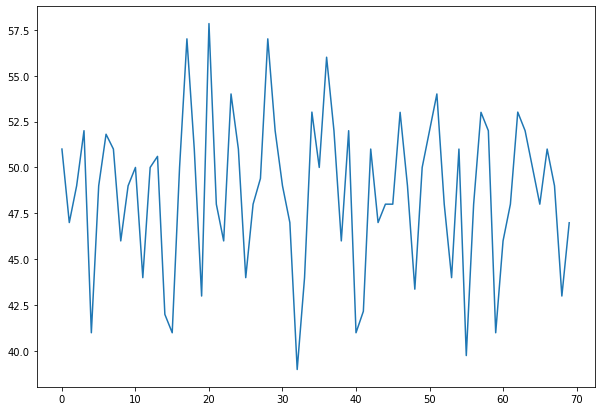

In [18]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
losses = []

# итерируемся
for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(train_dataloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = doctype(X_batch.float())
        y_pred = y_pred.to(device)
        loss_value = loss(y_pred.float(), y_batch.unsqueeze(1).float())
        loss_value.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss_value.item()
        
        losses.append(running_loss)
        running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')